# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Computing and visualizing transient global warming levels

30/6/2021

*J. Bedia* - [Santander Meteorology Group](http://www.meteo.unican.es). Dept. of Applied Mathematics and Computing Science. University of Cantabria, Santander, Spain.


In this notebook we reproduce some of the key steps for the determination of transient Global Warming Levels (GWLs). The computation of the period corresponding to a given GWL is carried out by means of a external function available in the Atlas repository, which is applied in this notebook to a single model. The example illustrates the whole process of data access, data selection and preparation, computation of GWL periods and visualization.

### Package dependencies
This notebook is based on R programming language and requires packages:

 * `magrittr` to pipe (`%>%`) sequences of data operations improving readability

In [1]:
library(magrittr)

### GWL calculation

The function [`getGWL`](../warming-levels/scripts/getGWL.R) performs the key task of GWL determination. It is an atomic function to compute the timing of a user-defined transient Global Warming Level, that uses as input a numeric vector of mean global annual temperature projections for a given GCM. This numeric vector must be named, using the corresponding years as names. Both pre-industrial baseline (default to 1850-1900) and transient period (usually up to year 2100) are concatenated in a single input vector.

The following example is intended to work with the global mean (land+sea) 2-m temperature data stored as _.csv_ files in the [datasets-aggregated-regionally](../datasets-aggregated-regionally) directory. 

We can load the `getGWL` function by issuing:

In [2]:
source("../warming-levels/scripts/getGWL.R", echo = TRUE)


> getGWL <- function(data, base.period = c(1850, 1900), 
+     proj.period = c(1971, 2100), window = 20, GWL = 2) {
+     if (length(base.period) != 2 .... [TRUNCATED] 


### Example for one single CMIP5 GCM

#### Reading input data

The transient GWLs of +1.5, +2, +3 and +4$^\circ$C are here calculated for one single CMIP5 GCM. The _MPI-ESM-MR r1i1p1_ ensemble member simulations forced by the RCP 8.5 scenario are picked as an example. Their data are located by searching with an adequate pattern into the data directory:

In [3]:
target <- "MPI-ESM-MR"
modelfiles <- list.files("../datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea", 
                         full.names = TRUE,
                         pattern = target) %>% print()

[1] "../datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_MPI-ESM-MR_r1i1p1_historical.csv"
[2] "../datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_MPI-ESM-MR_r1i1p1_rcp26.csv"     
[3] "../datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_MPI-ESM-MR_r1i1p1_rcp45.csv"     
[4] "../datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_MPI-ESM-MR_r1i1p1_rcp85.csv"     


The target GCM (and/or ensemble member, if it applies) can be directly chosen using the appropriate `target` pattern string, as in the example code above. Note that CMIP5 and CMIP6 datasets live in different directories, following the same reference syntax.

First, the historical experiment is read. It will provide the baseline for the GWL calculation. 

In [4]:
hist.regions <- grep("historical", modelfiles, value = TRUE) %>%
                read.table(header = TRUE, sep = ",", dec = ".", comment.char = "#") 
str(hist.regions)

'data.frame':	1872 obs. of  60 variables:
 $ date : Factor w/ 1872 levels "1850-01","1850-02",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ GIC  : num  -21.64 -21.07 -18.84 -16.01 -9.25 ...
 $ NWN  : num  -21.88 -19.91 -16.99 -6.06 2.27 ...
 $ NEN  : num  -22.112 -25.734 -19.455 -10.703 -0.514 ...
 $ WNA  : num  -4.51 0.909 -0.022 5.321 10.829 ...
 $ CNA  : num  -2.61 3.23 6.1 9.09 15.42 ...
 $ ENA  : num  2.35 3.76 7.4 8.49 13.79 ...
 $ NCA  : num  14.4 15 17.3 19.4 21.3 ...
 $ SCA  : num  24.4 24.8 25.5 26 26.2 ...
 $ CAR  : num  24.7 24.3 24.3 25 25.8 ...
 $ NWS  : num  21.9 22.3 22.2 22.1 21.6 ...
 $ NSA  : num  25.5 26.2 26.6 26.8 26.5 ...
 $ NES  : num  24.4 24.4 24.1 24.3 23.7 ...
 $ SAM  : num  22.9 22.5 22 22.8 21.5 ...
 $ SWS  : num  15.3 15.9 15.5 13.6 12.3 ...
 $ SES  : num  24.3 24.1 22.9 20.1 17.1 ...
 $ SSA  : num  10.22 11.58 10.16 6.69 5.29 ...
 $ NEU  : num  -5.24 -2.78 1 2.54 6.73 ...
 $ WCE  : num  -4.143 -0.295 6.266 9.529 12 ...
 $ EEU  : num  -14.907 -10.837 -0.776 5.821 13.95

This file contains regionally-aggregated (land+sea) monthly temperature data for all the IPCC AR6 reference regions. From this file, we just retain the first (`date`) and last (`world`) columns, average by years and prepare a single named vector with the years:

In [5]:
yrs <- hist.regions[["date"]] %>% gsub("-.*", "", .)
hist <- tapply(hist.regions[["world"]], INDEX = yrs, FUN = "mean", na.rm = TRUE)
names(hist) <- unique(yrs)

We extracted the year as a string from the `date` column and computed the yearly average of the `world` averaged data. The last command sets the years as names for the numeric vector. We can now have a first look at the historical experiment temperature for this model.

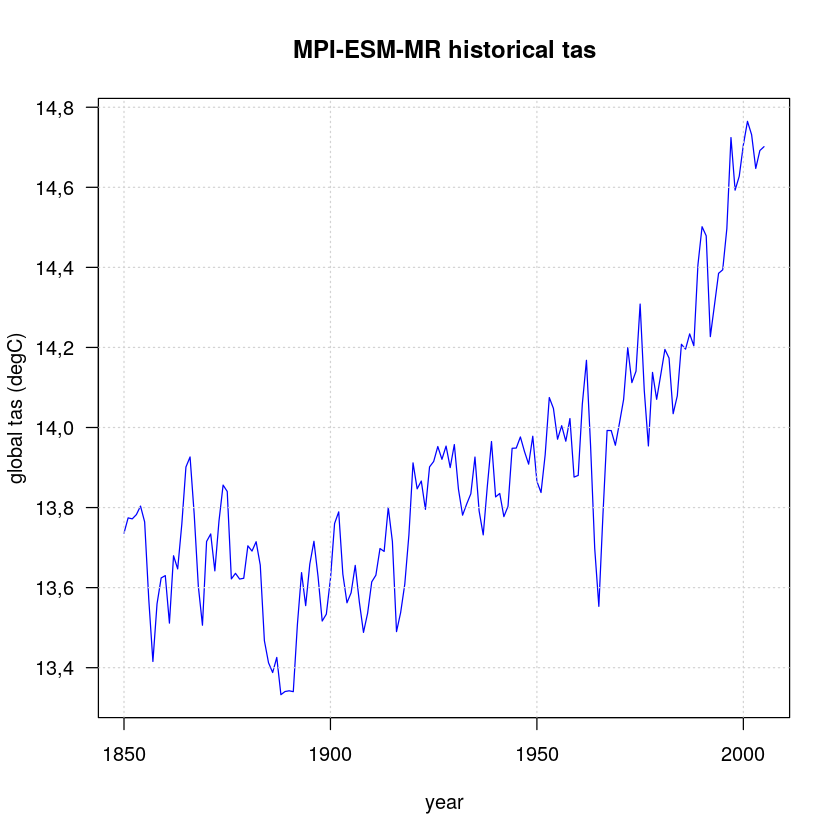

In [6]:
plot(x = as.integer(names(hist)),
     y = hist, 
     ylab = "global tas (degC)", xlab = "year",
     type = "l", col = "blue", las = 1)
grid()
title(paste(target, "historical tas"))


The same procedure is next carried out with the RCP 8.5 experiment data, adapting the pattern used in the regular expression to retrieve the corresponding data and repeating the rest of the steps:

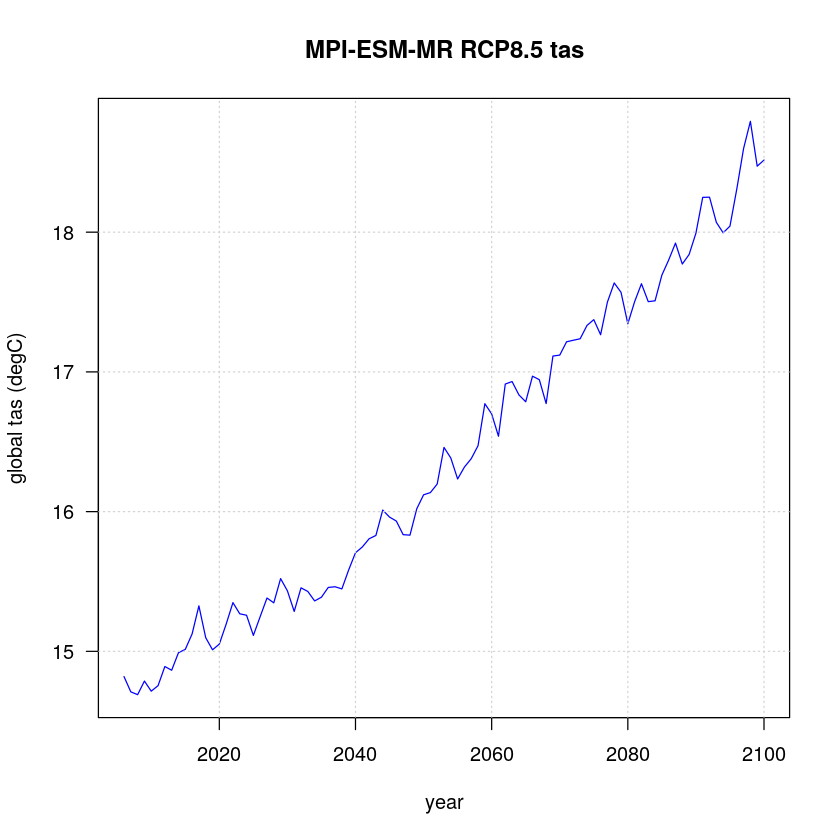

In [7]:
rcp85.regions <- grep("rcp85", modelfiles, value = TRUE) %>% 
                 read.table(header = TRUE, sep = ",", dec = ".", comment.char = "#")
yrs <- rcp85.regions[["date"]] %>% gsub("-.*", "", .)
rcp85 <- tapply(rcp85.regions[["world"]], INDEX = yrs, FUN = "mean", na.rm = TRUE)
names(rcp85) <- unique(yrs)

plot(x = as.integer(names(rcp85)),
     y = rcp85, 
     ylab = "global tas (degC)", xlab = "year",
     type = "l", col = "blue", las = 1)
grid()
title(paste(target, "RCP8.5 tas"))

We can now also plot the concatenated historical + RCP85 time series. A vertical dashed line is added to differentiate both experiments.

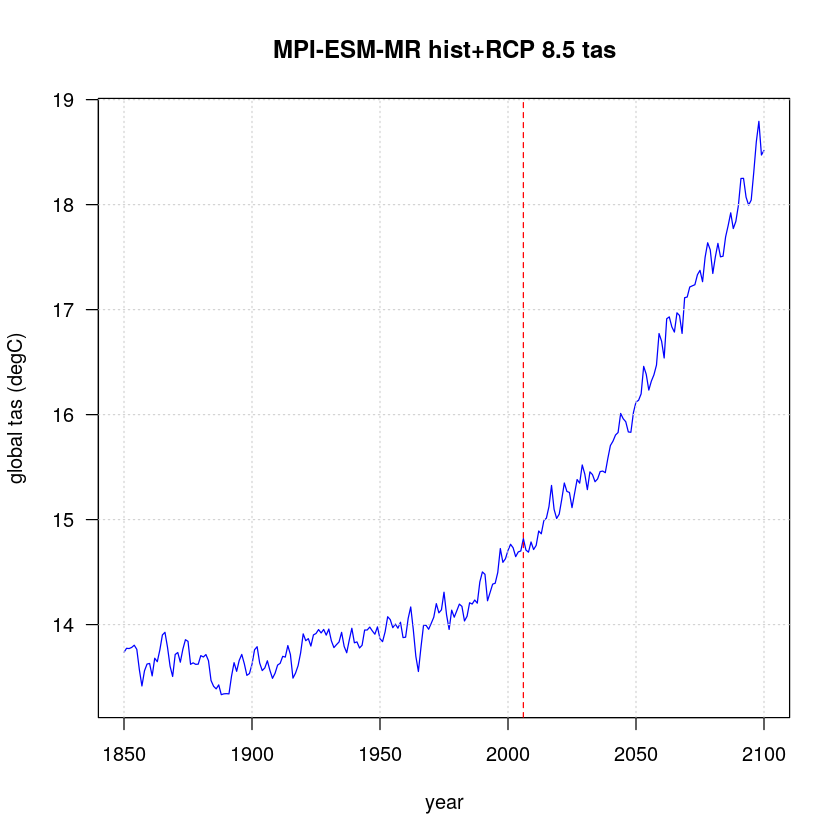

In [8]:
tas <- append(hist, rcp85)
plot(x = as.integer(names(tas)),
     y = tas, 
     ylab = "global tas (degC)", xlab = "year",
     type = "l", col = "blue", las = 1)
grid()
abline(v = 2006, col = "red", lty = 2)
title(paste(target, "hist+RCP 8.5 tas"))

#### Transient GWL calculation

For the IPCC WGI Interactive Atlas, the time periods for which +1.5, +2, +3 and +4 degree transient Global Warming Levels (GWLs) are reached (with respect to pre-industrial 1850-1900 mean value) are computed for CMIP5 and CMIP6 data using a 20-year moving window.

The default output of `getGWL` corresponds to the **central year (n) of the 20-year period** when the warming is first reached (the GWL period is thus **[n-9, n+10]**). This function will return **'NA'** when the GWL is not reached before (the central year) 2100. Note that the 20-year window width can be adjusted by the user to other arbitrary lengths. In that case, the interval will adapt accordingly.

The `tas` time series depicted in the previous time-series plot will serve as input for the `getGWL` function. In the next code chunk, the +1.5 degC GWL is calculated, considering the default baseline, pre-industrial period (1850-1900) and moving window width (20 years) used in the IPCC WG1 Atlas:

In [9]:
 gwl_1.5 <- getGWL(data = tas, 
                   base.period = c(1850, 1900),
                   proj.period = c(1971, 2100),
                   window = 20,
                   GWL = 1.5) %>% print()

[1] 2019
attr(,"interval")
[1] 2010 2029


In this particular example, the function returns an integer value (**2019**), corresponding to the *central year (n) of the 20-year window* for the selected GWL period. 

In [10]:
gwl_1.5

[1] 2019
attr(,"interval")
[1] 2010 2029

In addition, the period intervals (calculated in this case as *[n-9, n+10]*) are indicated by the `interval` attribute (**2010-2029**) and can be retrieved by:

In [11]:
attr(gwl_1.5, "interval")

[1] 2010 2029

Therefore, the calculation of several GWLs for this GCM/experiment is straightforward with just looping over the `GWL` parameter:

In [12]:
gwls <- c(1.5, 2, 3, 4)
central.years <- c()
for (i in 1:length(gwls)) {
    central.years[i] <- getGWL(data = tas, 
                               base.period = c(1850, 1900),
                               proj.period = c(1971, 2100),
                               window = 20,
                               GWL = gwls[i]) 
}

Finally, these warming levels are plotted on top of the GCM temperature series:

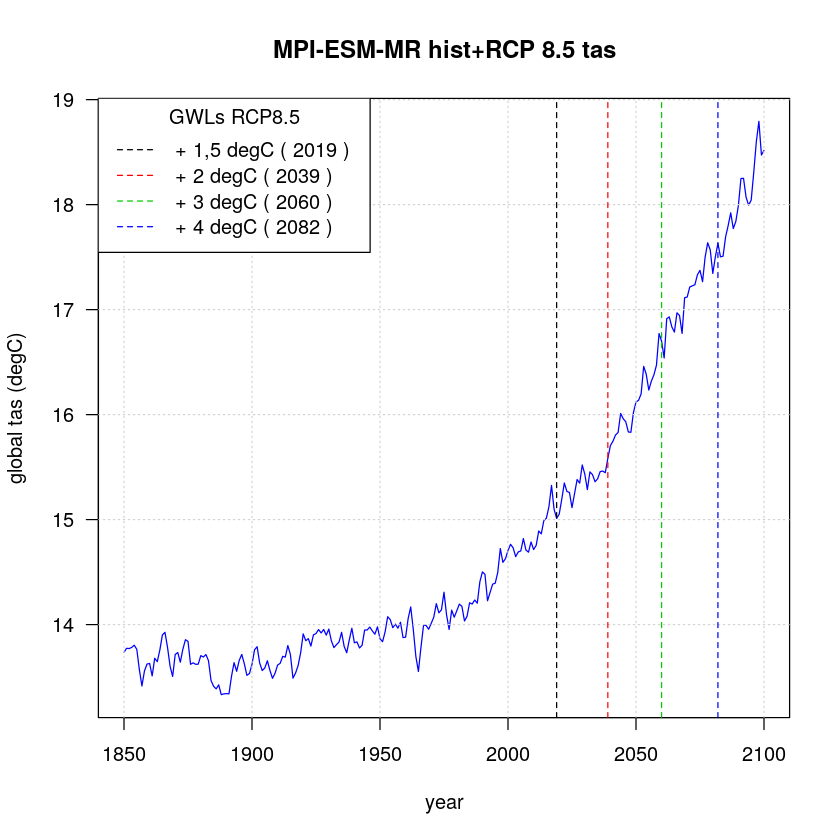

In [13]:
plot(x = as.integer(names(tas)),
     y = tas, 
     ylab = "global tas (degC)", xlab = "year",
     type = "l", col = "blue", las = 1)
grid()
title(paste(target, "hist+RCP 8.5 tas"))

## Indicate GWLs as vertical lines
colors <- 1:length(gwls)
line.type <- "dashed"
abline(v = central.years, col = colors, lty = line.type)
legend("topleft",title = "GWLs RCP8.5",
       paste("+", gwls, "degC (", central.years, ")"),
       lty = line.type, col = colors)

### Session Information

In [14]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/juaco/miniconda3/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=es_ES.UTF-8       
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] magrittr_2.0.1

loaded via a namespace (and not attached):
 [1] compiler_3.6.1  IRdisplay_0.7.0 pbdZMQ_0.3-3    tools_3.6.1    
 [5] htmltools_0.3.6 base64enc_0.1-3 crayon_1.4.1    Rcpp_1.0.6     
 [9] uuid_0.1-2      IRkernel_0.8.15 jsonlite_1.7.2  digest_0.6.18  
[13] repr_0.